In [1]:
import pandas as pd 
from statsforecast import StatsForecast 
from statsforecast.models import (
    AutoETS,
    AutoTheta,
    CrostonOptimized,
    HoltWinters,
    WindowAverage,
    Naive,
    SeasonalNaive
)
from statsforecast.utils import ConformalIntervals
import tsforge as tsf 
import numpy as np
from pathlib import Path
import os 
import matplotlib.pyplot as plt
import sys

MODEL_ZOO = [
    Naive(),
    CrostonOptimized(),
    WindowAverage(window_size=4, alias="MA4"), # often a strong baseline in retail forecasting 
    SeasonalNaive(season_length=52, alias="SN52"), #predict last years value 
    HoltWinters(season_length=52, alias="HW52"), #holtwinters is a special, simplified case of ETS 
    AutoTheta(
        season_length=52,
        decomposition_type="multiplicative",
    ), # automatic selection of the best Theta model/method, use multiplicative seasonlity 
    
    AutoETS(
        season_length=52,
        model="ZZZ", 
        damped=True,  # dampen the trend 
        phi=0.98,
    ), # AutoETS (Error,Trend,Seasonal) is a generalized State-Space Exponential Smoothing that automatically selects the best model
]

In [4]:
df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/data/output/m5_weekly.parquet"
)

In [5]:
# prepare statsforecast class

stat_fcst = StatsForecast(
    models=MODEL_ZOO,
    freq="W-SUN",  # set frequency to weekly
    n_jobs=-1,  # use all cpu cores
    fallback_model=Naive(),  # if we have any models that fail, fall back to naive
)


# Backtesting

* Cross-validation strategies for time series forecasting:
  * Rolling and Expanding Window: Here We Choose Rolling Window
    - this is an ideal choice for environments with ample data and volatile history

* Step Size = 1 (each fold advances by 1 time step)

* Windows = 5 (5-fold rolling window cross-validation)

* Horizon = 13
  
  

In [17]:
fill_df = tsf.fill_gaps(
    df=df,
    id_col='unique_id',
    time_col='ds',
    freq="W-SUN",
    start='global',
).assign(
    y = lambda df: df['y'].fillna(0)
)

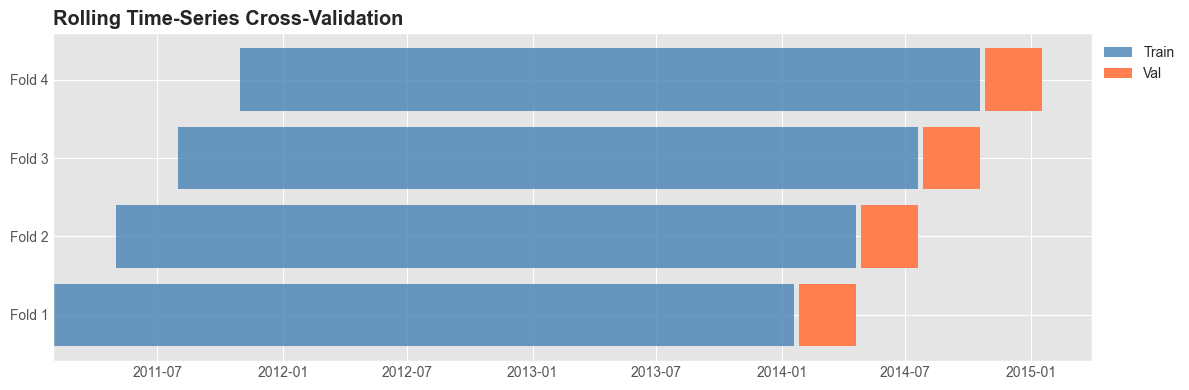

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# --- 1. Setup ---
# (Using your existing HORIZON, WINDOWS, STEP_SIZE, INPUT_SIZE, and dates)

plt.style.use("ggplot")  # Good defaults for spacing and grid
fig, ax = plt.subplots(figsize=(12, 4))
dates = fill_df.sort_values('ds')['ds'].unique()

HORIZON = 13
WINDOWS = 4
STEP_SIZE = 13  # step by 13
INPUT_SIZE = 52 * 3  # 3 years


# --- 2. Simplified Plotting Loop ---
for i in range(WINDOWS):
    # Calculate start/end indices for this fold
    tr_s, tr_e = i * STEP_SIZE, i * STEP_SIZE + INPUT_SIZE
    vl_s, vl_e = tr_e, tr_e + HORIZON

    # Map to dates
    d_tr_s, d_tr_e = dates[tr_s], dates[tr_e - 1]
    d_vl_s, d_vl_e = dates[vl_s], dates[vl_e - 1]

    # Draw Train & Validation bars
    ax.barh(
        i,
        d_tr_e - d_tr_s,
        left=d_tr_s,
        color="steelblue",
        alpha=0.8,
        label="Train" if i == 0 else "",
    )
    ax.barh(i, d_vl_e - d_vl_s, left=d_vl_s, color="coral", label="Val" if i == 0 else "")

# --- 3. Clean Up ---
ax.set_yticks(range(WINDOWS))
ax.set_yticklabels([f"Fold {i+1}" for i in range(WINDOWS)])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # Readable dates
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.set_title("Rolling Time-Series Cross-Validation", loc="left", fontweight="bold")

plt.tight_layout()
plt.show()


In [18]:
# statsforecast makes this easy, under the hood it repeatedly is calling .forecast() in a "for" loop 


HORIZON = 13
WINDOWS = 4
STEP_SIZE = 13 # step by 13
INPUT_SIZE = 52*3 # 3 years 

cv_args = {
            # CV args.. 
            "h": HORIZON,
            "n_windows":WINDOWS,
            "step_size":STEP_SIZE,
            "input_size":INPUT_SIZE,
            
            # id cols 
            "id_col":"unique_id",
            "time_col":"ds",
            "target_col":"y",

            # probabalistic intervals args
            "prediction_intervals":ConformalIntervals(n_windows=2,h=HORIZON,method='conformal_distribution'),

            "level":[80,95]} # get probabalistic forecasts (to be used later.. )


cv_results = stat_fcst.cross_validation(
    **cv_args,
    df=fill_df,
)

/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools

In [34]:
n_ids = cv_results['unique_id'].nunique()

assert cv_results.shape[0] == (n_ids * (WINDOWS * HORIZON)), f"Expected {n_ids * (WINDOWS * HORIZON)} rows, got {cv_results.shape[0]}"

In [19]:
cv_results.to_parquet("statsforecast_backtest.parquet")